# 5.12 tensorflow.keras による自然言語処理

## Keras, Janome, 「雑談対話コーパス」のダウンロード

### Janome のインストール

Anaconda の python 仮想環境 tf2_book4 に janome パッケージをインストールする。

<pre>
pip install janome
</pre>



In [1]:
! pip install janome

### 雑談対話コーパスのダウンロード

https://sites.google.com/site/dialoguebreakdowndetection/chat-dialogue-corpus
からダウンロードして 
<a href="../local/projectnextnlp-chat-dialogue-corpus.zip">
../local/projectnextnlp-chat-dialogue-corpus.zip</a>
の下に置き、
<a href="../local/projectnextnlp-chat-dialogue-corpus/">
../local/projectnextnlp-chat-dialogue-corpus</a>
として展開した。

## 対話データの抽出と加工

コーパスの Json/{init100,rest1046}/ フォルダに対話データがある。

In [2]:
import codecs

# file の内容を表示する
def catFile(path, start=0,n=-1):
    with codecs.open(path, 'r', 'utf-8') as f:
        contents = f.readlines()
    end = start + n
    if (n < 0) or (end >= len(contents)):
        end = len(contents)
    for i in range(start,end):
        print(contents[i], end='')

In [3]:
import os, glob
CORPUS_DIR = '../local/projectnextnlp-chat-dialogue-corpus'

p = os.path.join(CORPUS_DIR,'json','rest1046','*.json')
files = glob.glob(p)
print('-------------',files[0],'-----------------')
catFile(files[0], 40)

------------- ../local/projectnextnlp-chat-dialogue-corpus\json\rest1046\1409400437.log.json -----------------
                {
                    "annotator-id": "12_A", 
                    "breakdown": "X", 
                    "comment": "相手の発話を無視", 
                    "ungrammatical-sentence": "O"
                }
            ], 
            "speaker": "S", 
            "time": "2014-08-30 21:03:00", 
            "turn-index": 2, 
            "utterance": "朝から海に行きますか？？"
        }, 
        {
            "annotations": [], 
            "speaker": "U", 
            "time": "2014-08-30 21:03:27", 
            "turn-index": 3, 
            "utterance": "朝は忙しいので無理です"
        }, 
        {
            "annotations": [
                {
                    "annotator-id": "09_B", 
                    "breakdown": "T", 
                    "comment": "相手が明らかに行きたがっていないのにおかしい", 
                    "ungrammatical-sentence": "O"
                }, 
                {
                    "

## JSON ファイルを全て読み込んで正解ラベル、発話のリストを作る。

In [4]:
# 5-12-1 データの読み込み
# p.396
import os
import json
import codecs

file_path = os.path.join(CORPUS_DIR, 'json', 'rest1046')
file_dir = os.listdir(file_path)

utterance_txt =[]  # 人間の発話
system_txt = []     # システムの応答
label = []   # 正解ラベル

for file in file_dir:
    p = os.path.join(file_path,file)
    with open(p,  mode='r', encoding='utf-8') as f:
        json_data = json.load(f)
    for turn in json_data['turns']:
        turn_index = turn['turn-index']
        speaker = turn['speaker']
        utterance = turn['utterance']
        
        # 先頭行以外を処理
        if turn_index != 0:
            if speaker == 'U':    # 人間の発話(質問)
                u_text = utterance
            else:  # システムの応答が破綻かどうか
                a = ''
                sys = turn['utterance']
                t = turn['annotations'][0]   # first annotation
                a = t['breakdown']  # annotation's flag
                if a == 'O':   # 破綻していない
                    val = 0
                else:
                    val = 1
                utterance_txt.append(u_text)
                system_txt.append(sys)
                label.append(str(val))

In [5]:
# 5-12-2 読み込んだデータのサイズを出力する
print(len(utterance_txt))
print(len(system_txt))
print(len(label))

10460
10460
10460


In [6]:
# 5-13-3_5
for i in range(5):
    print(utterance_txt[i])
    print(system_txt[i])
    print(label[i])

いや、山に行きたいです
朝から海に行きますか？？
1
朝は忙しいので無理です
海まで散歩に行きますか？
1
海は遠いので難しいですね
海に行きませんか？？
0
私は山のほうがいいです
海は楽しいですね
1
魚釣りが楽しいですね
魚釣りは楽しいですね
1


## 発話テキストを形態素に分解する

<ul>
    <li><code>janome.tokenizer.Tokenizer()</code></li>
    <li><code>janome.tokenizer.Tokenizer.tokenize()</code></li>
</ul>


In [7]:
# 形態素解析の例
# p.400

from janome.tokenizer import Tokenizer
t = Tokenizer()
tokens = t.tokenize('わたしはPythonのプログラムです')
for token in tokens:
    print(token)

わたし	名詞,代名詞,一般,*,*,*,わたし,ワタシ,ワタシ
は	助詞,係助詞,*,*,*,*,は,ハ,ワ
Python	名詞,固有名詞,組織,*,*,*,Python,*,*
の	助詞,連体化,*,*,*,*,の,ノ,ノ
プログラム	名詞,サ変接続,*,*,*,*,プログラム,プログラム,プログラム
です	助動詞,*,*,*,特殊・デス,基本形,です,デス,デス


In [9]:
# Token#surface
# p.401 
tokens = t.tokenize('わたしはPythonのプログラムです')
print(tokens)

#print(tokens[0])   ### !!! Error p.401ではこのコードを書いているが、エラーとなる。

<generator object Tokenizer.__tokenize_stream at 0x000002274BF2D938>


In [10]:
# [自分へのメモ] p.401 のバグを出さないためには

tokens = t.tokenize('わたしはPythonのプログラムです')
ts = [ token for token in tokens]

print(ts[0])   ### indexで指定するにはgeneratorからリストに変換すればエラーとならない。

わたし	名詞,代名詞,一般,*,*,*,わたし,ワタシ,ワタシ


In [11]:
tokens = t.tokenize('わたしはPythonのプログラムです')
headline = [ token.surface for token in tokens]
print(headline)

['わたし', 'は', 'Python', 'の', 'プログラム', 'です']


In [12]:
print(ts[0].surface)
print(ts[0].part_of_speech)

わたし
名詞,代名詞,一般,*


In [14]:
# 5-12-6 人間の発話、システムの応答、正解ラベルをデータフレームにまとめる
# p.402
import pandas as pd

df = pd.DataFrame({
    'utterance_txt' : utterance_txt,
    'system_txt': system_txt,
    'label': label
    })

In [15]:
df

,utterance_txt,system_txt,label
0,いや、山に行きたいです,朝から海に行きますか？？,1
1,朝は忙しいので無理です,海まで散歩に行きますか？,1
2,海は遠いので難しいですね,海に行きませんか？？,0
3,私は山のほうがいいです,海は楽しいですね,1
4,魚釣りが楽しいですね,魚釣りは楽しいですね,1
...,...,...,...
10455,私はバナナも好きです,バナナは好きですね,0
10456,朝食で食べてます,朝食はご飯がいいですね,0
10457,私の家ではパンを食べています,パンは公園で食べてるのですか？,0
10458,家で食べてますよ,パンをほおばってるのですか？,0


In [17]:
# 5-13-7 破綻していない (0) / 破綻している (1) をカウントする
df['label'].value_counts()

0    5329
1    5131
Name: label, dtype: int64

In [20]:
# 5-13-8 形態素へ分解する
# p.403-404

from janome.tokenizer import Tokenizer
import re

def parse(utterance_txt):
    t = Tokenizer()
    separation_tmp = []
    for row in utterance_txt:
        tokens = t.tokenize(row)
        separation_tmp.append(
            [ token.surface for token in tokens if (
                (not re.match('記号', token.part_of_speech))
                and (not re.match('助詞', token.part_of_speech))
                and (not re.match('助動詞', token.part_of_speech))
                )
            ])
        while separation_tmp.count('') > 0:
             separation_tmp.remove('')
    return separation_tmp

In [21]:
# 発話を形態素に分解する
df['utterance_token'] = parse(df['utterance_txt'])
# 応答を形態素に分解する
df['system_token'] = parse(df['system_txt'])

In [22]:
df

,utterance_txt,system_txt,label,utterance_token,system_token
0,いや、山に行きたいです,朝から海に行きますか？？,1,"[いや, 山, 行き]","[朝, 海, 行き]"
1,朝は忙しいので無理です,海まで散歩に行きますか？,1,"[朝, 忙しい, 無理]","[海, 散歩, 行き]"
2,海は遠いので難しいですね,海に行きませんか？？,0,"[海, 遠い, 難しい]","[海, 行き]"
3,私は山のほうがいいです,海は楽しいですね,1,"[私, 山, ほう, いい]","[海, 楽しい]"
4,魚釣りが楽しいですね,魚釣りは楽しいですね,1,"[魚釣り, 楽しい]","[魚釣り, 楽しい]"
...,...,...,...,...,...
10455,私はバナナも好きです,バナナは好きですね,0,"[私, バナナ, 好き]","[バナナ, 好き]"
10456,朝食で食べてます,朝食はご飯がいいですね,0,"[朝食, 食べ]","[朝食, ご飯, いい]"
10457,私の家ではパンを食べています,パンは公園で食べてるのですか？,0,"[私, 家, パン, 食べ, い]","[パン, 公園, 食べ, てる, の]"
10458,家で食べてますよ,パンをほおばってるのですか？,0,"[家, 食べ]","[パン, ほおばっ, てる, の]"


In [24]:
# 5-12-9 発話と応答それぞれの形態素の数を登録する
# p.405
df['u_token_len'] = df['utterance_token'].apply(len)
df['s_token_len'] = df['system_token'].apply(len)

In [25]:
df

,utterance_txt,system_txt,label,utterance_token,system_token,u_token_len,s_token_len
0,いや、山に行きたいです,朝から海に行きますか？？,1,"[いや, 山, 行き]","[朝, 海, 行き]",3,3
1,朝は忙しいので無理です,海まで散歩に行きますか？,1,"[朝, 忙しい, 無理]","[海, 散歩, 行き]",3,3
2,海は遠いので難しいですね,海に行きませんか？？,0,"[海, 遠い, 難しい]","[海, 行き]",3,2
3,私は山のほうがいいです,海は楽しいですね,1,"[私, 山, ほう, いい]","[海, 楽しい]",4,2
4,魚釣りが楽しいですね,魚釣りは楽しいですね,1,"[魚釣り, 楽しい]","[魚釣り, 楽しい]",2,2
...,...,...,...,...,...,...,...
10455,私はバナナも好きです,バナナは好きですね,0,"[私, バナナ, 好き]","[バナナ, 好き]",3,2
10456,朝食で食べてます,朝食はご飯がいいですね,0,"[朝食, 食べ]","[朝食, ご飯, いい]",2,3
10457,私の家ではパンを食べています,パンは公園で食べてるのですか？,0,"[私, 家, パン, 食べ, い]","[パン, 公園, 食べ, てる, の]",5,5
10458,家で食べてますよ,パンをほおばってるのですか？,0,"[家, 食べ]","[パン, ほおばっ, てる, の]",2,4


In [26]:
# 5-12-10 単語の出現回数を記録して辞書を作成する
# p.406
from collections import Counter
import itertools

def makedictionary(data):
    return Counter(itertools.chain(* data))   # chain('ab', (1,2), [5, 6]])->['a','b',1,2,5, 6] 複数のiterator を一つにまとめる

In [32]:
# 5-12-11 単語を出現回数順 (降順) に並べ替えて連番をふる関数
def update_word_dictionary(worddic):
    word_list = []
    word_dic = {}
    for w in worddic.most_common():  # 頻出順
        word_list.append(w[0])
    for i, word in enumerate(word_list, start=1):
        word_dic.update({word: i})
    return word_dic

In [33]:
# 5-12-12 単語を出現頻度の数値に置き換える関数
# p.407
def bagOfWords(word_dic, token):
    return [[ word_dic[word] for word in sp] for sp in token ]

In [34]:
# 5-12-13 発話を {単語:出現回数} の辞書にする
# p.407
utter_word_frequency = makedictionary(df['utterance_token'])

print(list(utter_word_frequency)[:5])

['いや', '山', '行き', '朝', '忙しい']


In [35]:
# 5-12-14 応答を {単語:出現回数} の辞書にする
# p.407
system_word_frequency = makedictionary(df['system_token'])

print(list(system_word_frequency)[:5])

['朝', '海', '行き', '散歩', '楽しい']


In [36]:
# 5-12-15 発話の単語辞書を単語の頻度順 (降順) で並べ替えて連番を割り当てる
# p.408
utter_word_dic = update_word_dictionary(utter_word_frequency)
print(list(utter_word_dic)[:5])

['ん', 'し', 'そう', '好き', 'の']


In [37]:
# 5-12-16 応答の単語辞書を単語の頻度順 (降順) で並べ替えて連番を割り当てる
# p.408
system_word_dic = update_word_dictionary(system_word_frequency)
print(list(system_word_dic)[:5])

['いい', 'の', '好き', 'ん', '海']


In [38]:
# 5-12-17 辞書のサイズを変数に登録する
utter_dic_size = len(utter_word_dic)
system_dic_size = len(system_word_dic)

print(utter_dic_size, system_dic_size)

5330 4428


In [39]:
# 5-12-18 単語を出現頻度の数値に置き換える
# p.409
train_utter = bagOfWords(utter_word_dic, df['utterance_token'])
train_system = bagOfWords(system_word_dic, df['system_token'])

In [40]:
# 5-12-19 数値に置き換えた発話の例
# p.409
print(train_utter[:5])

[[56, 85, 13], [111, 177, 433], [15, 868, 150], [9, 85, 54, 6], [1737, 44]]


In [41]:
# 5-12-20 数値に置き換えた応答の例
# p.410
print(train_system[:5])

[[49, 5, 14], [5, 354, 14], [5, 14], [5, 21], [1738, 21]]


In [43]:
# 5-12-21 発話と応答それぞれの最大サイズを取得する
# p.410
UTTER_MAX_SIZE = len(sorted(train_utter, key=len, reverse=True)[0])
SYSTEM_MAX_SIZE = len(sorted(train_system, key=len, reverse=True)[0])

print(UTTER_MAX_SIZE, SYSTEM_MAX_SIZE)

18 41


In [50]:
# 5-12-22 単語データの配列を同一のサイズに揃える関数
# p.411
from tensorflow.keras.preprocessing import sequence

def padding_sequences(data, max_len):
    return sequence.pad_sequences(
        data,
        maxlen=max_len,
        padding='post',
        value=0.0
    )

In [51]:
# 5-12-23 発話の単語配列のサイズを最長サイズに合わせる
# p.411
train_U = padding_sequences(train_utter, UTTER_MAX_SIZE)

print(train_U.shape)
print(train_U[:5])

(10460, 18)
[[  56   85   13    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [ 111  177  433    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [  15  868  150    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [   9   85   54    6    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [1737   44    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]]


In [52]:
# 5-12-23 応答の単語配列のサイズを最長サイズに合わせる
# p.412
train_S = padding_sequences(train_system, SYSTEM_MAX_SIZE)

print(train_S.shape)
print(train_S[:5])

(10460, 41)
[[  49    5   14    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]
 [   5  354   14    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]
 [   5   14    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]
 [   5   21    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]
 [1738   21    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0  

## RNN (LSTM) を構築して発話が破綻しているかを学習する


In [65]:
# 5-12-25 RNN モデルの構築
# p.415-417

import tensorflow as tf

def getModel(utter_max_size, system_max_size, utter_dic_size, system_dic_size):
    
    # Input Layers
    utterance = tf.keras.layers.Input(shape=(utter_max_size,), name='utterance')
    system = tf.keras.layers.Input(shape=(system_max_size,), name='system')
    u_token_len = tf.keras.layers.Input(shape=[1], name='u_token_len')
    s_token_len = tf.keras.layers.Input(shape=[1], name='s_token_len')
    
    # Embedding Layers
    emb_u = tf.keras.layers.Embedding(input_dim=utter_dic_size+100, output_dim=128)(utterance)
    emb_s = tf.keras.layers.Embedding(input_dim=system_dic_size+100, output_dim=128)(system)
    emb_u_len = tf.keras.layers.Embedding(input_dim=utter_max_size+1, output_dim=5)(u_token_len)
    emb_s_len = tf.keras.layers.Embedding(input_dim=system_max_size+1, output_dim=5)(s_token_len)
    
    # Recurrent Layers
    rnn_layer1_1 = tf.keras.layers.GRU(128, return_sequences=True)(emb_u)
    rnn_layer1_2 = tf.keras.layers.GRU(128, return_sequences=True)(rnn_layer1_1)
    rnn_layer1_3 = tf.keras.layers.GRU(128, return_sequences=False)(rnn_layer1_2)

    rnn_layer2_1 = tf.keras.layers.GRU(128, return_sequences=True)(emb_s)
    rnn_layer2_2 = tf.keras.layers.GRU(128, return_sequences=True)(rnn_layer2_1)
    rnn_layer2_3 = tf.keras.layers.GRU(128, return_sequences=False)(rnn_layer2_2)

    # Fully-Connected Layers
    x = tf.keras.layers.concatenate([
            tf.keras.layers.Flatten()(emb_u_len),
            tf.keras.layers.Flatten()(emb_s_len),
            rnn_layer1_3,
            rnn_layer2_3
        ])
    
    x = tf.keras.layers.Dense(512, kernel_initializer='normal', activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(256, kernel_initializer='normal', activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(128, kernel_initializer='normal', activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
     
                         
    # Output Layers
    output = tf.keras.layers.Dense(2, activation='softmax')(x)
    
    # Model
    model = tf.keras.Model(
                inputs=[utterance, system, u_token_len, s_token_len],
                outputs=output
            )
    return model

In [66]:
model = getModel(UTTER_MAX_SIZE, SYSTEM_MAX_SIZE, utter_dic_size, system_dic_size)

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
utterance (InputLayer)          [(None, 18)]         0                                            
__________________________________________________________________________________________________
system (InputLayer)             [(None, 41)]         0                                            
__________________________________________________________________________________________________
embedding_14 (Embedding)        (None, 18, 128)      695040      utterance[0][0]                  
__________________________________________________________________________________________________
embedding_15 (Embedding)        (None, 41, 128)      579584      system[0][0]                     
_______________________________________________________________________________________

In [74]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),  # 学習率は後で設定する(だんだん減らす)
    metrics=[ 'accuracy']
    )

### 学習する


In [67]:
# 確認する
df[['u_token_len']]

,u_token_len
0,3
1,3
2,3
3,4
4,2
...,...
10455,3
10456,2
10457,5
10458,2


In [68]:
# 確認する
df[['s_token_len']]

,s_token_len
0,3
1,3
2,2
3,2
4,2
...,...
10455,2
10456,3
10457,5
10458,4


In [71]:
# 5-12-26
# p.419
import numpy as np

trainX = {
    'utterance': train_U,
    'system': train_S,
    'u_token_len': np.array(df['u_token_len']),
    's_token_len': np.array(df['s_token_len'])
}

trainY = tf.keras.utils.to_categorical(df['label'], 2)

In [76]:
# 5-12-27 学習を実行する
# p.419-420
import math

lr_min = 0.0001
lr_max = 0.001

def step_decay(epoch):
    drop = 0.5
    epochs_drop = 10.0
    lrate = lr_max * math.pow(drop, math.floor(epoch/epochs_drop))
    if lrate < lr_min:
        lrate = lr_min
    return lrate

In [77]:
# 5-12-27続き
# p.420

batch_size = 32
epoch = 100

history = model.fit(
    trainX,
    trainY,
    batch_size=batch_size,
    epochs=epoch,
    verbose=1,
    validation_split=0.2,
    shuffle=True,
    callbacks=[ tf.keras.callbacks.LearningRateScheduler(step_decay) ]
    )

Epoch 1/100
262/262 [==============================] - 6s 24ms/step - loss: 0.6936 - accuracy: 0.5043 - val_loss: 0.6969 - val_accuracy: 0.5072
Epoch 2/100
262/262 [==============================] - 5s 19ms/step - loss: 0.6886 - accuracy: 0.5288 - val_loss: 0.6913 - val_accuracy: 0.5048
Epoch 3/100
262/262 [==============================] - 5s 19ms/step - loss: 0.6857 - accuracy: 0.5356 - val_loss: 0.6887 - val_accuracy: 0.5268
Epoch 4/100
262/262 [==============================] - 5s 19ms/step - loss: 0.6861 - accuracy: 0.5368 - val_loss: 0.6893 - val_accuracy: 0.5196
Epoch 5/100
262/262 [==============================] - 5s 19ms/step - loss: 0.6853 - accuracy: 0.5425 - val_loss: 0.6917 - val_accuracy: 0.5220
Epoch 6/100
262/262 [==============================] - 5s 20ms/step - loss: 0.6844 - accuracy: 0.5419 - val_loss: 0.6896 - val_accuracy: 0.5105
Epoch 7/100
262/262 [==============================] - 6s 22ms/step - loss: 0.6845 - accuracy: 0.5452 - val_loss: 0.6931 - val_accuracy:

262/262 [==============================] - 5s 19ms/step - loss: 0.1114 - accuracy: 0.9428 - val_loss: 14.4882 - val_accuracy: 0.5373
Epoch 58/100
262/262 [==============================] - 5s 19ms/step - loss: 0.1142 - accuracy: 0.9412 - val_loss: 13.9161 - val_accuracy: 0.5325
Epoch 59/100
262/262 [==============================] - 5s 19ms/step - loss: 0.1109 - accuracy: 0.9422 - val_loss: 13.7570 - val_accuracy: 0.5320
Epoch 60/100
262/262 [==============================] - 5s 20ms/step - loss: 0.1101 - accuracy: 0.9460 - val_loss: 14.5086 - val_accuracy: 0.5277
Epoch 61/100
262/262 [==============================] - 5s 19ms/step - loss: 0.1071 - accuracy: 0.9441 - val_loss: 14.8387 - val_accuracy: 0.5325
Epoch 62/100
262/262 [==============================] - 5s 19ms/step - loss: 0.1078 - accuracy: 0.9459 - val_loss: 15.3294 - val_accuracy: 0.5359
Epoch 63/100
262/262 [==============================] - 5s 20ms/step - loss: 0.1081 - accuracy: 0.9463 - val_loss: 14.9411 - val_accuracy

In [78]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_history(history):
  fig, ax = plt.subplots(1, 2, figsize=(6*2.5, 4))
  ax[0].plot(history['loss'], c='b', label='loss')
  ax[0].plot(history['val_loss'], c='r', label='val_loss')
  ax[0].legend(loc='upper right')
  ax[0].set_xlabel('epochs')
  ax[0].set_ylabel('loss')

  ax[1].plot(history['accuracy'], c='b', label='acc')
  ax[1].plot(history['val_accuracy'], c='r', label='val_acc')
  ax[1].legend(loc='lower right')
  ax[1].set_xlabel('epochs')
  ax[1].set_ylabel('accuracy')

  plt.subplots_adjust(hspace=0.5)
  plt.show()

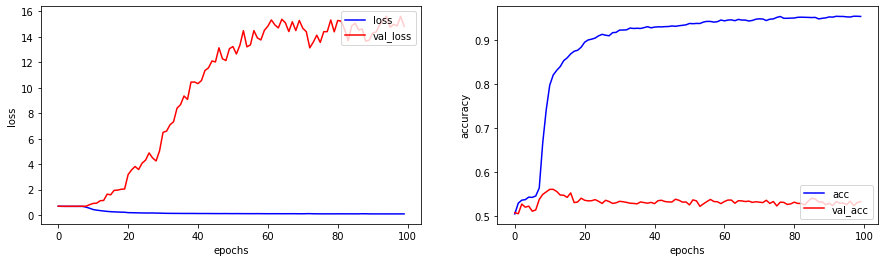

In [79]:
plot_history(history.history)

訓練時のaccuracyは1.0に近くなるが、検証時のaccuracyは0.5を超えるが 0.6 には届かない。
これは完全に overfitting の状態である。

2クラス分類なので、accuracyが約0.5ということは、あてずっぽうに答えているのとほとんど変わらない。
したがって、この方法では「会話が破綻しているかどうか」は学習できないと思われる。